## Interactive lammps

In [1]:
from lammps import PyLammps

In [2]:
L = PyLammps()

LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
LAMMPS output is captured by PyLammps wrapper


####  SET SIMULATION CONDITIONS

In [3]:
L.command("units lj")
L.command("atom_style full")
L.command("pair_style lj/cut 2.5")
L.command("bond_style harmonic")
L.command("special_bonds fene")

L.command("dimension 3")
L.command("boundary p p p")
L.command("neighbor 0.8 bin")

In [4]:
L.command('read_data lipit.data')

Reading data file ...
  orthogonal box = (-21.1659 -21.1659 -2.71938) to (21.1659 21.1659 3.35194)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  7776 atoms
  reading velocities ...
  7776 velocities
  scanning bonds ...
  2 = max bonds/atom
  reading bonds ...
  7680 bonds
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:   0          1          1         
  special bond factors coul: 0          1          1         
  8 = max # of 1-2 neighbors
  8 = max # of special neighbors
  special bonds CPU = 0.00145888 secs
  read_data CPU = 0.02792 secs


In [5]:
L.command('change_box all boundary p p f')

Changing box ...


In [6]:
L.command('change_box all z delta -40.0 20.0 units box')

Changing box ...
  orthogonal box = (-21.1659 -21.1659 -42.7194) to (21.1659 21.1659 23.3519)


####  DEFINE VARIABLES

In [7]:
L.command('variable velocityBullet equal -2')
L.command('variable radiusBullet equal 5')
L.command('variable hBullet equal 5+${radiusBullet}')

#### CHOOSE THERMODYNAMIC OUTPUT

In [8]:
L.command('thermo  200')
L.command('thermo_style    custom step temp press ebond epair ke')

#### CLAMP BOUNDARIES OF THE FILM

In [9]:
L.command('region hole cylinder z 0 0 20 -10.0 10.0 side in units box')
L.command('group hole region hole')
L.command('group film type 1 2')
L.command('group base subtract film hole')

L.command('fix nailed base setforce 0.0 0.0 0.0')
L.command('velocity base set 0.0 0.0 0.0 units box')
L.command('velocity hole create 0.1 239472')

5448 atoms in group hole
7776 atoms in group film
2328 atoms in group base


#### CREATE BULLET ABOVE THE FILM

In [10]:
L.command('lattice diamond 7.2')
L.command('region 1 sphere 0 0 ${hBullet} ${radiusBullet} side in units box')
L.command('create_atoms 3 region 1 units box')
L.command('group indent type 3')
L.command('neigh_modify exclude group indent indent')
L.command('fix 1 indent rigid single')
L.command('velocity indent set 0.0 0.0 -2 units box')

Lattice spacing in x,y,z = 1.03574 1.03574 1.03574
Created 3760 atoms
  create_atoms CPU = 0.00249219 secs
3760 atoms in group indent
1 rigid bodies with 3760 atoms


#### SHOOT!

In [11]:
L.command('fix nve1 hole nve')
L.command('compute stressA all stress/atom NULL')
L.command('compute 1 indent ke')
L.command('fix kin all ave/time 1 1 10 c_1 file kinetic.data')
L.command('dump mydump all custom 200 Conf.dat id type x y z c_stressA[1] c_stressA[2] c_stressA[3]')
L.command('dump_modify mydump sort id')
L.command('run 8000')

Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 3.3
  ghost atom cutoff = 3.3
  binsize = 1.65, bins = 26 26 41
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/newton
      stencil: half/bin/3d/newton
      bin: standard
Setting up Verlet run ...
  Unit style    : lj
  Current step  : 0
  Time step     : 0.005
Per MPI rank memory allocation (min/avg/max) = 15.06 | 15.06 | 15.06 Mbytes
Step Temp Press E_bond E_pair KinEng 
       0   0.71467575  0.045966277  0.033376706    -3.913345   0.72269851 
     200    0.7146774  0.043336522  0.035016071    -3.915117   0.72270017 
     400   0.72956468  0.066344152  0.035528484   -3.9393562   0.73775458 
     600   0.72372256  0.046115457  0.040826199   -3.9472678   0.73184687 
     800   0.72351932  0.056048598  0.043344244   -3.9546738   0.73164135 

### Visualisation

In [12]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import nglview as nv
import MDAnalysis as mda

u = mda.Universe('Conf.dat',format='LAMMPSDUMP')

In [13]:
atoms = u.atoms

In [14]:
view = nv.show_mdanalysis(atoms)

In [15]:
view

NGLWidget(max_frame=40)

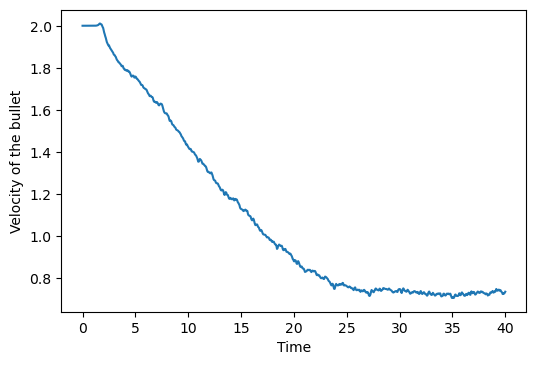

In [17]:
import numpy as np
import matplotlib.pyplot as plt

kin = np.loadtxt('kinetic.data')
time = 0.005*kin[:,0]
vel = np.sqrt(2*kin[:,1]/3760.0)

plt.figure(dpi=100)
plt.plot(time,vel);
plt.xlabel('Time');
plt.ylabel("Velocity of the bullet");